<a href="https://colab.research.google.com/github/HilkarSoberanes/MachineLearning/blob/main/AutoencoderCats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder Implementation using Cats


We have used the cats from the Dogs vs Cats Kanggle dataset  (https://www.kaggle.com/c/dogs-vs-cats) for training an Autoencoder with convolutional layers.

### Importing Necessary Modules/Packages

In [69]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline
import seaborn as sns
from PIL import Image, ImageFilter, ImageEnhance
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
from numpy import asarray
train_images = []
test_images = []

### Loading the Data

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
import zipfile

zip_files = ['test1', 'train']

for zip_file in zip_files:
    with zipfile.ZipFile("drive/MyDrive/MachineLearning/DogsVSCats/dogs-vs-cats/{}.zip".format(zip_file),"r") as z:
        z.extractall(".")
        print("{} unzipped".format(zip_file))

test1 unzipped
train unzipped


In [72]:
TRAIN_DIR_PATH = './train'
file_names = os.listdir(TRAIN_DIR_PATH)
print('There are {} number of images in directory.'.format(len(file_names)))

There are 25000 number of images in directory.


In [73]:
def to_dataframe(file_names):
    files, labels = list(), list()
    for file in file_names:
        files.append(file)
        labels.append(file[:3])
    df = pd.DataFrame({'filename':files, 'label':labels})
    return df

df = to_dataframe(file_names)

In [74]:
df.head()

,filename,label
0,cat.5754.jpg,cat
1,cat.7128.jpg,cat
2,cat.703.jpg,cat
3,dog.3914.jpg,dog
4,cat.567.jpg,cat


### Seperating Cats from Dogs

In [75]:
cat = [file for file in file_names if file[:3]=='cat'] #cat images
dog = [file for file in file_names if file[:3]=='dog'] #dog images

In [76]:
mkdir cats

mkdir: cannot create directory ‘cats’: File exists


In [77]:
cd cats

/content/cats


In [78]:
mkdir cats

mkdir: cannot create directory ‘cats’: File exists


In [79]:
cd ..

/content


### Saving the Cats images a new directory

In [80]:
for i in range(10000):
  train = Image.open('./train/'+cat[i])
  train.save('./cats/cats/'+cat[i])

### Data preprocesing

In [82]:
img_size = 256
train_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    './cats/',
    target_size=(img_size,img_size),
    shuffle=True,
    class_mode='input',
    batch_size=64
)

Found 10000 images belonging to 1 classes.


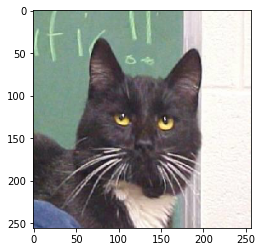

In [83]:
img,lab = next(train_data)

plt.imshow(img[0])

### Build Autoencoder

This model will compress an image of dimensions 256x256x3 to a of shape 4x4x512 which can be represented as a 128x64x1 image

In [84]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

#encoder
input_image = layers.Input(shape=(img_size,img_size,3))
x = layers.Conv2D(16, (3, 3),strides=(2,2),activation="relu", padding="same")(input_image)#128
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3, 3),strides=(2,2), activation="relu", padding="same")(x)#64
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3),strides=(2,2), activation="relu", padding="same")(x)#32
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3),strides=(2,2), activation="relu", padding="same")(x)#16
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3, 3),strides=(2,2), activation="relu", padding="same")(x)#8
x = layers.BatchNormalization()(x)
x = layers.Conv2D(512, (3, 3),strides=(2,2), activation="relu", padding="same")(x)#4
encoder_output = layers.BatchNormalization()(x)
 
latent_shape = (4,4,512)
    
#decoder
decoder_input = layers.Input(shape=latent_shape)
x = layers.Conv2DTranspose(512, (3, 3),strides=(2,2), activation="relu", padding="same")(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(256, (3, 3), strides=2,activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
decoder_output = layers.Conv2DTranspose(3, (3, 3), padding="same", activation="sigmoid")(x)

#autoencoder
encoder = Model(input_image, encoder_output)
decoder = Model(decoder_input,decoder_output)
autoencoder = Model(input_image, decoder(encoder_output))
autoencoder.compile(optimizer="Adam", loss="mean_absolute_error") #deafult lr = 0.001
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        1849

### Train Autoencoder

In [85]:
history = autoencoder.fit(train_data,epochs=50,verbose=2)

Epoch 1/50
157/157 - 54s - loss: 0.1081 - 54s/epoch - 341ms/step
Epoch 2/50
157/157 - 49s - loss: 0.0760 - 49s/epoch - 309ms/step
Epoch 3/50
157/157 - 49s - loss: 0.0699 - 49s/epoch - 312ms/step
Epoch 4/50
157/157 - 48s - loss: 0.0665 - 48s/epoch - 309ms/step
Epoch 5/50
157/157 - 49s - loss: 0.0657 - 49s/epoch - 311ms/step
Epoch 6/50
157/157 - 50s - loss: 0.0639 - 50s/epoch - 315ms/step
Epoch 7/50
157/157 - 49s - loss: 0.0629 - 49s/epoch - 309ms/step
Epoch 8/50
157/157 - 48s - loss: 0.0622 - 48s/epoch - 309ms/step
Epoch 9/50
157/157 - 49s - loss: 0.0614 - 49s/epoch - 314ms/step
Epoch 10/50
157/157 - 48s - loss: 0.0605 - 48s/epoch - 309ms/step
Epoch 11/50
157/157 - 48s - loss: 0.0599 - 48s/epoch - 308ms/step
Epoch 12/50
157/157 - 49s - loss: 0.0600 - 49s/epoch - 312ms/step
Epoch 13/50
157/157 - 49s - loss: 0.0588 - 49s/epoch - 310ms/step
Epoch 14/50
157/157 - 49s - loss: 0.0589 - 49s/epoch - 310ms/step
Epoch 15/50
157/157 - 49s - loss: 0.0586 - 49s/epoch - 313ms/step
Epoch 16/50
157/157

### Training Curve

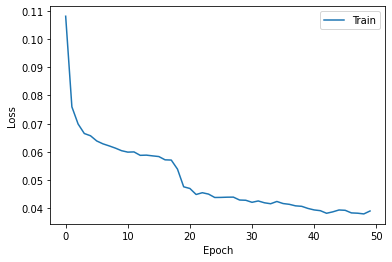

In [86]:
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

### Checking out training results

1/1 [==============================] - 0s 18ms/step


<function matplotlib.pyplot.show(*args, **kw)>

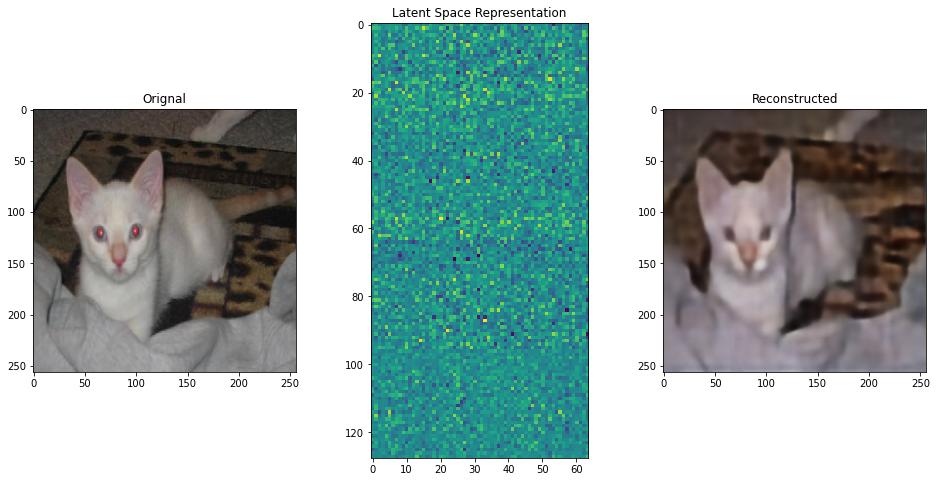

In [102]:
i, l = next(train_data)

f = plt.figure(figsize=(16,8))

latent_image_shape = (128,64)

f.add_subplot(1,3,1)
plt.imshow(i[0])
plt.title("Orignal")
im = np.reshape(i[0],(1,img_size,img_size,3))

pred = encoder.predict(np.reshape(i[0],(1,img_size,img_size,3)))
f.add_subplot(1,3,2)
plt.imshow(np.reshape(pred,latent_image_shape))
plt.title("Latent Space Representation")

pred = autoencoder.predict(np.reshape(i[0],(1,img_size,img_size,3)))
f.add_subplot(1,3,3)
plt.imshow(np.reshape(pred,(img_size,img_size,3)))
plt.title("Reconstructed")


plt.show

In [114]:
img, lab = next(train_data)

In [118]:
encoded_imgs = encoder.predict(img[0:20])
decoded_imgs = decoder.predict(encoded_imgs)

1/1 [==============================] - 0s 288ms/step


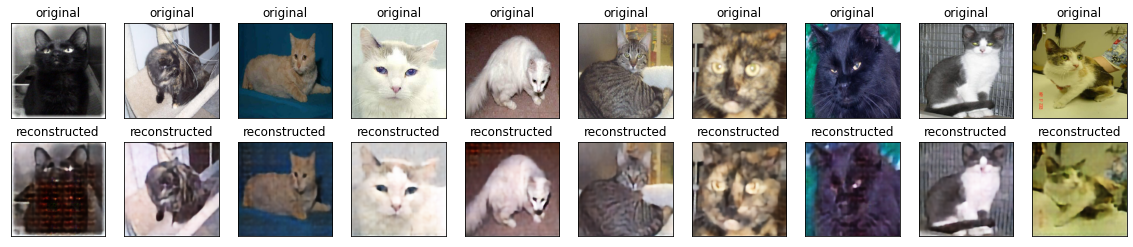

In [120]:
n = 10
plt.figure(figsize=(20, 4))
for j in range(n):
  # display original
  ax = plt.subplot(2, n, j + 1)
  plt.imshow(img[j])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, j + 1 + n)
  plt.imshow(decoded_imgs[j])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

### Checking out what sort of output we get from noise sampled from normal distribution

1/1 [==============================] - 0s 64ms/step


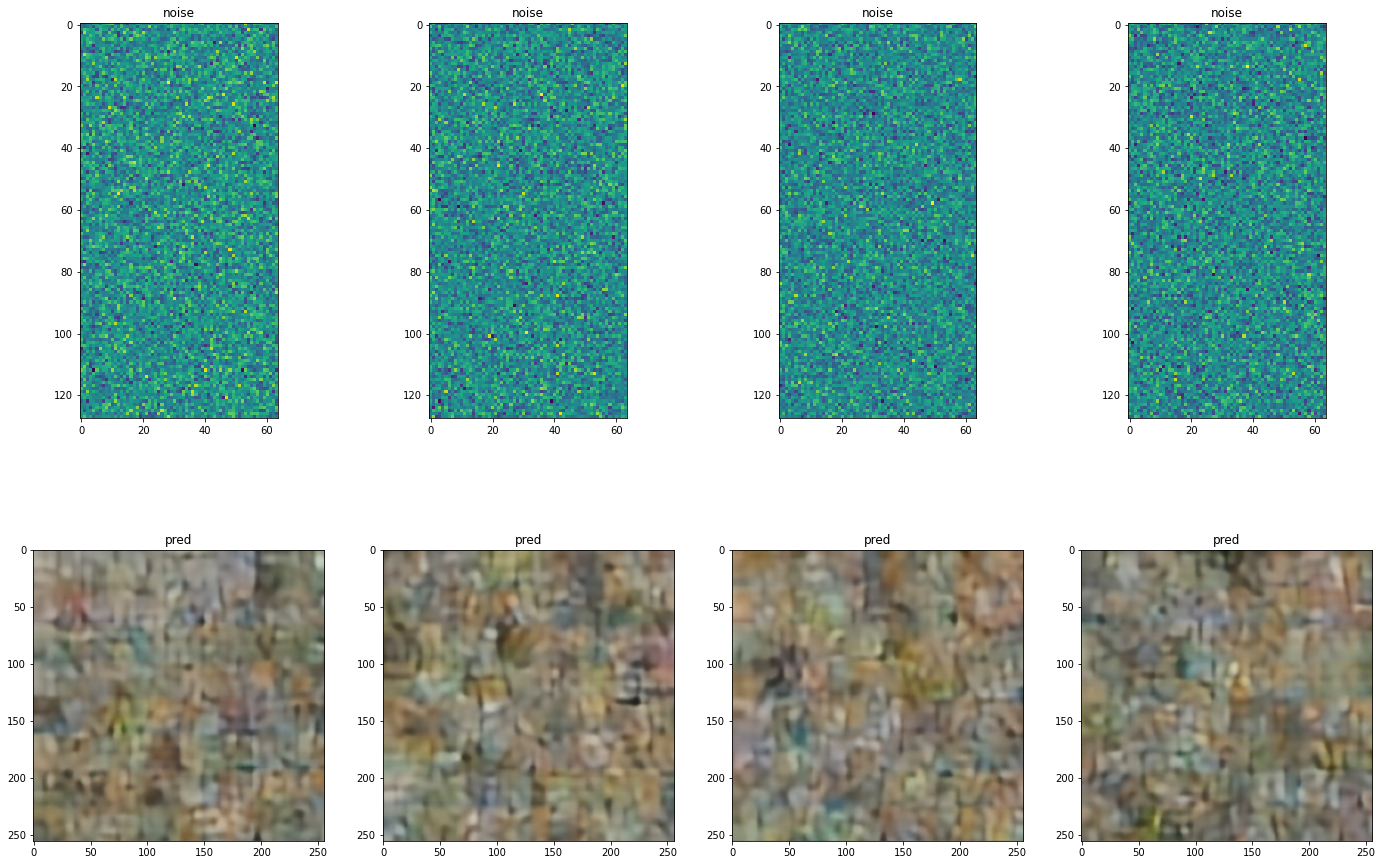

In [91]:
noise = np.random.normal(size=(4,4,4,512))
f = plt.figure(figsize=(24,16))

for i in range(4):
    f.add_subplot(2,4,i+5)
    plt.title("pred")
    pred = decoder.predict(noise)
    plt.imshow(np.reshape(pred[i],(img_size,img_size,3)))
    
    f.add_subplot(2,4,i+1)
    plt.title("noise")
    plt.imshow(np.reshape(noise[i],latent_image_shape))

plt.show()

### Interpolating two images
Moving in latent space between two images and seeing them bleed into each other

1/1 [==============================] - 0s 23ms/step


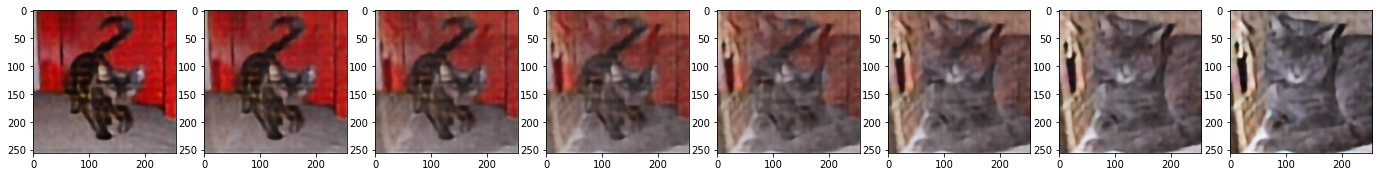

In [122]:
i, l = next(train_data)

cat_one_latent = encoder.predict(np.reshape(i[0],(1,img_size,img_size,3)))
cat_two_latent = encoder.predict(np.reshape(i[1],(1,img_size,img_size,3)))

f = plt.figure(figsize=(24,16))

alphaValues = np.linspace(0,1,8)
plot_index = 1

for alpha in alphaValues:
    vec = cat_one_latent*(1-alpha) + cat_two_latent*alpha
    decoded = decoder.predict(vec)
    f.add_subplot(1,8,plot_index)
    plt.imshow(np.reshape(decoded,(img_size,img_size,3)))
    plot_index +=1
    